# Prediction Seniority: Fine-Tuning a Classification Model



In [159]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_absolute_error, classification_report

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback,
)
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Data Setup

We use `df_seniority` as the supervised fine-tuning dataset (training distribution).
We use `jobs_annotated_df` as a separate, real-world evaluation set (production distribution)
to estimate out-of-production generalization error.


In [160]:
# GitHub raw helper
GH_USER = "luisadosch"
GH_REPO = "Final-Project-snapAddy"
BRANCH = "main"


def get_github_url(relative_path):
    return f"https://raw.githubusercontent.com/{GH_USER}/{GH_REPO}/{BRANCH}/{relative_path}"

In [161]:
jobs_annotated = pd.read_csv(get_github_url("data/processed/jobs_annotated.csv"))
df_seniority = pd.read_csv(get_github_url("data/raw/seniority-v2.csv"))

# test set from annotated CVs (ACTIVE only) -> out-of-production set
jobs_annotated_df = jobs_annotated.loc[
    jobs_annotated["status"] == "ACTIVE",
    ["position", "seniority"]
].copy()

jobs_annotated_df = jobs_annotated_df.rename(columns={"position": "text", "seniority": "label"})

# keep only (text, label)
df_seniority = df_seniority[["text", "label"]].copy()
jobs_annotated_df = jobs_annotated_df[["text", "label"]].copy()

print("fine tuning data:", len(df_seniority), "CV labeled data:", len(jobs_annotated_df))
print("fine-tune label counts:\n", df_seniority["label"].value_counts())
print("out-of-production label counts:\n", jobs_annotated_df["label"].value_counts())


fine tuning data: 9428 CV labeled data: 623
fine-tune label counts:
 label
Senior        3733
Lead          3546
Director       984
Management     756
Junior         409
Name: count, dtype: int64
out-of-production label counts:
 label
Professional    216
Management      192
Lead            125
Senior           44
Director         34
Junior           12
Name: count, dtype: int64


* We are aware that the label Professional appears in jobs_annotated_df but does not exist in df_seniority. Therefore, we fine-tune using a regression (ordinal) setup instead of pure classification, so the model can still map titles onto the seniority scale even when a class is missing in the fine-tuning label set.

* There is also class imbalance in the fine-tuning data: Senior and Lead dominate, while Junior is relatively rare. This can bias the model toward predicting the majority classes (especially Senior/Lead) for ambiguous titles.

## Train / Validation / Test split (fine-tuning dataset)

* We split the fine-tuning dataset into train/val/test.
* Train is used to update weights, validation is used for early stopping,
and the held-out test provides an in-distribution estimate.

In [162]:
train_df_base, temp_df = train_test_split(
    df_seniority,
    test_size=0.30,              # 70% train, 30% temp
    stratify=df_seniority["label"],
    random_state=42,
)

val_df_base, df_seniority_test = train_test_split(
    temp_df,
    test_size=0.50,              # 15% val, 15% test
    stratify=temp_df["label"],
    random_state=42,
)

print("train:", len(train_df_base), "val:", len(val_df_base), "test:", len(df_seniority_test))
print("train label counts:\n", train_df_base["label"].value_counts())
print("val label counts:\n", val_df_base["label"].value_counts())
print("test label counts:\n", df_seniority_test["label"].value_counts())

train: 6599 val: 1414 test: 1415
train label counts:
 label
Senior        2613
Lead          2482
Director       689
Management     529
Junior         286
Name: count, dtype: int64
val label counts:
 label
Senior        560
Lead          532
Director      147
Management    113
Junior         62
Name: count, dtype: int64
test label counts:
 label
Senior        560
Lead          532
Director      148
Management    114
Junior         61
Name: count, dtype: int64


* We use a stratified train/validation/test split to ensure that each subset reflects the original seniority distribution.

* The training set is used to learn model parameters.

* The validation set is used for early stopping and model selection, helping to prevent overfitting.

* The test set is kept completely unseen during training and tuning to provide an unbiased in-distribution performance estimate.


In [163]:
# we choose ordinal mapping for the seniority classes
ORD_MAP = {
    "Junior": 1.0,
    "Professional": 2.0,
    "Senior": 3.0,
    "Lead": 4.0,
    "Management": 5.0,
    "Director": 6.0,
}
INV_ORD = {v: k for k, v in ORD_MAP.items()}

In [164]:
def add_synthetic(train_df: pd.DataFrame, synthetic_csv_relpath: str) -> pd.DataFrame:
    syn = pd.read_csv(get_github_url(synthetic_csv_relpath))
    syn = syn[["position", "seniority"]].copy()

    id2label = {v: k for k, v in ORD_MAP.items()}
    syn["label"] = syn["seniority"].map(id2label)
    syn = syn.rename(columns={"position": "text"})
    syn = syn.dropna(subset=["text", "label"])

    out = pd.concat([train_df[["text", "label"]], syn[["text", "label"]]], ignore_index=True)
    return out

* We use xlm-roberta-base because our job titles appear in multiple languages, and the model is trained on multilingual data.

* in our experiments, xlm-roberta-base performed better than DistilBERT, especially on the CV (out-of-production) dataset.

* we tokenize job titles using the model’s native tokenizer, applying truncation and padding to a fixed length to ensure consistent inputs during fine-tuning.

This setup allows the model to capture multilingual and domain-specific wording in job titles while remaining computationally feasible.

In [165]:
MODEL_CKPT = "xlm-roberta-base"
MAX_LEN = 48

tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
    )

In [166]:
def to_hf_dataset(df: pd.DataFrame, label_col: str = "labels") -> Dataset:
    ds = Dataset.from_pandas(df[["text", label_col]].copy(), preserve_index=False)
    ds = ds.map(tokenize, batched=True)
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", label_col])
    return ds

In [167]:
def eval_split(trainer, train_ds, val_ds, test_ds):
    train_metrics = trainer.evaluate(train_ds)
    val_metrics   = trainer.evaluate(val_ds)
    test_metrics  = trainer.evaluate(test_ds)
    print("train:", train_metrics)
    print("val:  ", val_metrics)
    print("test: ", test_metrics)
    return train_metrics, val_metrics, test_metrics


* We evaluate the fine-tuned model on three splits (train/val/test) to compare in-sample vs out-of-sample performance.

* Train metrics estimate in-sample error (how well the model fits the training distribution).

* Validation metrics are used for model selection / early stopping and help detect overfitting during training.

* Test metrics provide an unbiased in-distribution generalization estimate (out-of-sample error on unseen data from the same source as training).

* If train is much better than val/test, it suggests overfitting; if all three are similar, generalization is likely stable.

In [168]:
def loss_curves(trainer):
    logs = pd.DataFrame(trainer.state.log_history)

    train_loss = logs.dropna(subset=["loss"])[["step", "loss"]].copy()
    eval_loss  = logs.dropna(subset=["eval_loss"])[["step", "eval_loss"]].copy()

    plt.figure()
    plt.plot(train_loss["step"], train_loss["loss"])
    plt.xlabel("step")
    plt.ylabel("train loss")
    plt.title("Train loss")
    plt.show()

    plt.figure()
    plt.plot(eval_loss["step"], eval_loss["eval_loss"])
    plt.xlabel("step")
    plt.ylabel("eval loss")
    plt.title("Eval loss")
    plt.show()

    return logs

* We plot training loss and validation (eval) loss over steps to understand the learning dynamics during fine-tuning.

* Training loss shows how well the model is fitting the training data as optimization progresses.

* Eval loss tracks generalization on the validation set and is the main signal for detecting overfitting.

* If training loss keeps decreasing but eval loss stops improving or starts increasing, the model is likely overfitting and we should stop earlier (or regularize).

* If both curves decrease and stay relatively close, training is stable and the model generalizes better.

# Regression Fine-tuning (Ordinal Seniority Targets)

* We map ordered seniority classes to a numeric scale and fine-tune a transformer with a regression head.
* This avoids a hard failure when the 'Professional' class is missing from the production-like CV dataset.
* Evaluation reports include MAE and thresholded accuracy/F1 by converting predicted scores back into label bins. We do this because our other models are evaluated with accuracy, and this way it is easier for us to compare the different models.

In [169]:
def score_to_label(s: float) -> str:
  # because we used accuracy for other classification models, we also want to get an accuracy here
    if s < 1.5: return "Junior"
    if s < 2.5: return "Professional"
    if s < 3.5: return "Senior"
    if s < 4.5: return "Lead"
    if s < 5.5: return "Management"
    return "Director"

def compute_metrics_reg(eval_pred):
    preds, labels = eval_pred
    scores = np.squeeze(preds)
    mae = mean_absolute_error(labels, scores)

    y_pred = [score_to_label(float(s)) for s in scores]
    y_true = [INV_ORD[float(int(round(x)))] for x in labels]

    return {
        "mae": mae,
        "acc_thresh": accuracy_score(y_true, y_pred),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
    }


In [170]:
def predict_table_reg(trainer, ds, df_text_label):
    pred = trainer.predict(ds)
    scores = np.squeeze(pred.predictions)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_score"] = scores
    out["pred_label"] = [score_to_label(float(s)) for s in scores]
    out["abs_err"] = (out["pred_score"] - out["label"].map(ORD_MAP).astype(float)).abs()
    return out.sort_values("abs_err", ascending=False)

We set these TrainingArguments on regression & classification to get a stable fine-tuning run and a fair model selection (best checkpoint) on the validation set.

* Learning rate 1e-5
Small LR is safer for transformer fine-tuning (especially with noisy job titles). It updates weights slowly to avoid unstable jumps / forgetting. We also choose this because we experimented with different rates and this one gave us the best output.

* Batch sizes train=16, eval=32
Train batch is kept moderate for GPU memory. Eval batch can be larger because no gradients are stored, so it’s faster.

* num_train_epochs=10 + EarlyStopping(patience=2)
We allow enough epochs to converge, but stop early if validation stops improving. This helps prevent overfitting while still giving the model a chance.

* weight_decay=0.05
Regularization that discourages overly large weights → usually improves generalization on text tasks.

* warmup_ratio=0.06
Warmup ramps up the learning rate at the start so training is smoother (often prevents early instability).

* eval_strategy="epoch" and save_strategy="epoch"
We evaluate and save checkpoints at the end of each epoch. This matches well with early stopping and “best model” selection.

* load_best_model_at_end=True + metric_for_best_model="mae" + greater_is_better=False
We’re doing regression (ordinal seniority mapped to numbers), so MAE is the natural metric: “how far off are we on average?”. Lower is better, so greater_is_better=False.
At the end we automatically reload the checkpoint with the lowest validation MAE.

* fp16=True
Mixed precision speeds up training and reduces VRAM usage (typical on Colab GPUs).

* report_to="none"
Disables wandb/tensorboard logging to avoid setup friction in Colab.

* logging_strategy="steps", logging_steps=50
Frequent enough logging to later plot loss curves and see if training is stable.

* dataloader_num_workers=0
More stable in Colab environments (avoids some multiprocessing issues).

In [171]:
def run_regression(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, out_dir: str = "seniority_ft_reg"):
    tr = train_df.copy()
    va = val_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(ORD_MAP).astype(float)
    va["labels"] = va["label"].map(ORD_MAP).astype(float)
    te["labels"] = te["label"].map(ORD_MAP).astype(float)

    train_ds = to_hf_dataset(tr, label_col="labels")
    val_ds   = to_hf_dataset(va, label_col="labels")
    test_ds  = to_hf_dataset(te, label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=1,
        problem_type="regression",
    )

    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="mae",
        greater_is_better=False,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_reg,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )


    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_reg(trainer, train_ds, tr[["text", "label"]])
    val_pred   = predict_table_reg(trainer, val_ds,   va[["text", "label"]])
    test_pred  = predict_table_reg(trainer, test_ds,  te[["text", "label"]])

    return trainer, (train_pred, val_pred, test_pred)



## Classification Fine-tuning (Discrete Labels)

* After establishing a stable regression baseline, we also fine-tune a multi-class
classification model on seniority labels.

* This is feasible because we augment the training data with synthetic samples,
which introduces the previously missing label `Professional` and aligns the
label space with the CV data.

* However, even after augmentation, class imbalance remains—especially for
`Professional`. To address this, we apply oversampling **only on the training
split**, while keeping validation and test distributions unchanged.

* Validation data is used for early stopping and model selection, the held-out test
set provides an in-distribution performance estimate, and CV data is used to
evaluate out-of-production generalization error.

In [172]:
def compute_metrics_cls(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }


In [173]:
def predict_table_cls(trainer, ds, df_text_label, id2label):
    pred = trainer.predict(ds)
    probs = pred.predictions
    y_pred = np.argmax(probs, axis=-1)

    out = df_text_label.copy().reset_index(drop=True)
    out["pred_id"] = y_pred
    out["pred_label"] = [id2label[int(i)] for i in y_pred]
    out["correct"] = (out["pred_label"] == out["label"])
    return out

In [174]:
def report_cls(trainer, ds, id2label):
    pred = trainer.predict(ds)
    y_pred = np.argmax(pred.predictions, axis=-1)
    y_true = pred.label_ids
    print(classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))]))

We use the same training hyperparameters as in the regression setup for the same
reasons (training stability, regularization, and fair model comparison).

The main difference is the model-selection metric:

- `metric_for_best_model="eval_f1_macro"`:  
  For classification, we evaluate discrete label quality. Macro F1 treats all
  classes equally and is therefore well suited for imbalanced class distributions.

- `greater_is_better=True`:  
  Unlike regression (MAE), higher values of F1 indicate better performance.


In [175]:
def oversample_df(df, label_col="label", random_state=42):
    max_n = df[label_col].value_counts().max()
    parts = []
    for lab, g in df.groupby(label_col):
        parts.append(resample(g, replace=True, n_samples=max_n, random_state=random_state))
    return pd.concat(parts).sample(frac=1, random_state=random_state).reset_index(drop=True)

def run_classification(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, out_dir: str = "seniority_ft_cls"):
    # label space ONLY from train_df (no leakage)
    label_list = sorted(train_df["label"].unique())
    label2id = {l: i for i, l in enumerate(label_list)}
    id2label = {i: l for l, i in label2id.items()}

    tr = train_df.copy()
    va = val_df.copy()
    te = test_df.copy()

    tr["labels"] = tr["label"].map(label2id).astype(int)
    va["labels"] = va["label"].map(label2id)
    te["labels"] = te["label"].map(label2id)

    print("labels:", label_list)
    print("val missing labels:", int(va["labels"].isna().sum()))
    print("test missing labels:", int(te["labels"].isna().sum()))

    # drop rows with unseen labels (important for out-of-production where labels may differ)
    va = va.dropna(subset=["labels"]).copy()
    te = te.dropna(subset=["labels"]).copy()
    va["labels"] = va["labels"].astype(int)
    te["labels"] = te["labels"].astype(int)

    # oversample train only
    train_os = oversample_df(tr, label_col="label")
    train_ds = to_hf_dataset(train_os, label_col="labels")
    val_ds   = to_hf_dataset(va,       label_col="labels")
    test_ds  = to_hf_dataset(te,       label_col="labels")

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_CKPT,
        num_labels=len(label2id),
        id2label=id2label,
        label2id=label2id,
    )

    args = TrainingArguments(
        output_dir=out_dir,
        learning_rate=1e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=10,
        weight_decay=0.05,
        warmup_ratio=0.06,
        do_eval=True,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        greater_is_better=True,
        fp16=True,
        report_to="none",
        dataloader_num_workers=0,
        logging_strategy="steps",
        logging_steps=50,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics_cls,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
    )

    trainer.train()

    eval_split(trainer, train_ds, val_ds, test_ds)
    loss_curves(trainer)

    train_pred = predict_table_cls(trainer, train_ds, train_os[["text", "label"]], id2label)
    val_pred   = predict_table_cls(trainer, val_ds,   va[["text", "label"]],      id2label)
    test_pred  = predict_table_cls(trainer, test_ds,  te[["text", "label"]],      id2label)

    report_cls(trainer, val_ds, id2label)

    return trainer, (train_pred, val_pred, test_pred), (label2id, id2label)


## Model Runs

### Data and evaluation design

We evaluate on two datasets because they answer two different questions:  
`df_seniority` is our clean fine-tuning dataset, so we split it into train/val/test to train the model, do early stopping on validation, and report a fair in-distribution test score.  
`jobs_annotated_df` comes from real CVs, so we keep it completely separate and only evaluate after training to see how well the model transfers to production-like input (different wording, noise, and label frequencies).


## 1. Regression (no synthetic data, no oversampling)

We start with a regression using only the original `df_seniority` dataset for finetuning.  
At this stage we **don’t** add synthetic samples and we **don’t** oversample any classes, so we can measure the model’s “natural” performance before applying imbalance fixes.


Map:   0%|          | 0/6599 [00:00<?, ? examples/s]

Map:   0%|          | 0/1414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1415 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3324470351.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mae,Acc Thresh,F1 Macro
1,0.661500,0.507572,0.502793,0.599010,0.474842
2,0.119500,0.116925,0.253476,0.921499,0.715452
3,0.048700,0.067945,0.178161,0.983734,0.975227
4,0.051100,0.043916,0.165229,0.992928,0.990790
5,0.056600,0.045200,0.175897,0.995050,0.993379
6,0.017300,0.055349,0.200929,0.995050,0.993379


train: {'eval_loss': 0.04295135289430618, 'eval_mae': 0.16329771280288696, 'eval_acc_thresh': 0.9954538566449462, 'eval_f1_macro': 0.8297232665054367, 'eval_runtime': 3.529, 'eval_samples_per_second': 1869.952, 'eval_steps_per_second': 58.657, 'epoch': 6.0}
val:   {'eval_loss': 0.043915629386901855, 'eval_mae': 0.16522933542728424, 'eval_acc_thresh': 0.9929278642149929, 'eval_f1_macro': 0.9907896406158541, 'eval_runtime': 0.8151, 'eval_samples_per_second': 1734.653, 'eval_steps_per_second': 55.205, 'epoch': 6.0}
test:  {'eval_loss': 0.05711996182799339, 'eval_mae': 0.1732180267572403, 'eval_acc_thresh': 0.9872791519434629, 'eval_f1_macro': 0.8244898988573931, 'eval_runtime': 0.8052, 'eval_samples_per_second': 1757.339, 'eval_steps_per_second': 55.887, 'epoch': 6.0}


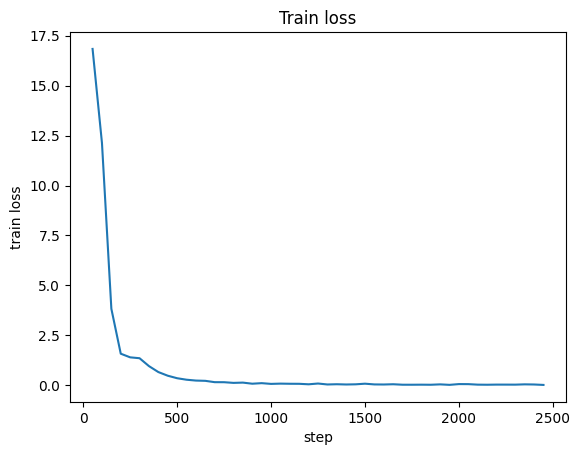

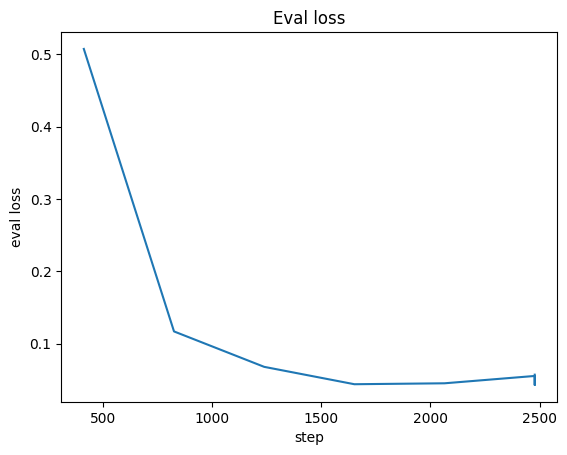

In [176]:
# In-distribution evaluation (df_seniority test split)
reg_trainer, (reg_train_pred, reg_val_pred, reg_test_pred) = run_regression(
    train_df_base,
    val_df_base,
    df_seniority_test,
    out_dir="seniority_ft_reg_base"
)

### Regression results (in-distribution)

- **Training loss** drops very quickly at the beginning and then smoothly converges toward zero. This indicates stable optimization and no training instability.
- **Validation loss** decreases strongly in the first epochs, then fluctuates slightly but remains low. Small oscillations are normal and expected for validation loss.
- There is **no divergence** between train and validation loss, which suggests no severe overfitting.

Overall, the curves support that the model converged properly and that early stopping around epoch 8 is reasonable.

### Interpretation of the metrics

- **MAE** is low and very similar across splits  
  * In Sample MAE (on training data): ~0.175  
  * MAE on validation data: ~0.180  
  * MAE on Test data: ~0.185  
  This indicates good generalization within the training distribution.

The regression model clearly learns the fine-tuning dataset and transfers well to the held-out **in-distribution** validation/test splits.  
Train/val/test performance is very close, so there is no strong sign of overfitting on this dataset.  
However, these numbers only tell us how well the model generalizes **within the fine-tuning distribution** — performance on real CV titles (out-of-distribution) still needs to be checked separately.

In [177]:
# Out-of-production evaluation (CV dataset)
reg_cv_pred = predict_table_reg(
    reg_trainer,
    to_hf_dataset(jobs_annotated_df.assign(labels=jobs_annotated_df["label"].map(ORD_MAP).astype(float)), label_col="labels"),
    jobs_annotated_df[["text", "label"]]
)

Map:   0%|          | 0/623 [00:00<?, ? examples/s]

In [178]:
print("MAE of CV data"               , reg_cv_pred["abs_err"].mean())
print("CV threshold-accuracy:", (reg_cv_pred["pred_label"] == reg_cv_pred["label"]).mean())


MAE of CV data 0.7608417247692616
CV threshold-accuracy: 0.5088282504012841


### Regression results (on annotated CV data)

On the CV dataset, performance drops substantially:

- **MAE ≈ 0.82**, compared to ~0.18 in-distribution  
- **Threshold accuracy ≈ 51%**, meaning only about half of the CV titles are mapped to the correct seniority bin

This gap indicates a **strong distribution shift** between the fine-tuning data and real CV job titles.

To understand *how* these errors occur (which labels are confused with which), we analyze a **confusion matrix** on the CV data next.


In [179]:
# Confusion matrix (all predictions) as counts
confusion_counts = pd.crosstab(
    reg_cv_pred["label"],       # true label
    reg_cv_pred["pred_label"],  # predicted label
    dropna=False
)

print("Confusion Matrix (All Predictions) – Counts (True label = rows, Predicted = columns)")
display(confusion_counts)


Confusion Matrix (All Predictions) – Counts (True label = rows, Predicted = columns)


pred_label,Director,Junior,Lead,Management,Professional,Senior
label,,,,,,
Director,31,0,3,0,0,0
Junior,0,5,2,0,0,5
Lead,0,3,84,3,1,34
Management,21,7,13,136,1,14
Professional,0,42,30,7,23,114
Senior,1,2,3,0,0,38


The confusion matrix reveals the following insights about our predictions on the cv data:
* Clear distribution shift: Professional is the most frequent label in CV data but does not exist at all in the fine-tuning dataset, explaining many downstream confusions.

* Professional → Senior/Lead: The model often predicts Senior or Lead for Professional CV titles because these are the most frequent classes (& closest) seen during training. It also often predicts Junior for Professional but not as often, which is probably because this class is underrepresented in the fine-tuning data.

* Class imbalance effect: Senior and Lead dominate the fine-tuning data, so the model has a bias toward predicting these labels in ambiguous cases. This is why we also include oversampling in our next model approach.

* Rare CV labels: Junior and Director are underrepresented in CV data, making their predictions less stable (-> we also try to solve this with oversampling in the next step)

* Consistent error pattern: Most mistakes align with adjacent seniority levels, which is expected given both the ordinal structure and the shifted label distribution.

In [180]:
errors = reg_cv_pred[reg_cv_pred["pred_label"] != reg_cv_pred["label"]]
top_errors = (
    errors.groupby(["label", "pred_label"])
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print("Most Frequent Errors (True → Predicted) – Counts")
display(top_errors)


Most Frequent Errors (True → Predicted) – Counts


,label,pred_label,count
15,Professional,Senior,114
12,Professional,Junior,42
6,Lead,Senior,34
13,Professional,Lead,30
7,Management,Director,21
11,Management,Senior,14
9,Management,Lead,13
14,Professional,Management,7
8,Management,Junior,7
2,Junior,Senior,5


Additionally, we report the most frequent (true → predicted) error pairs, which are dominated by `Professional` cases, reflecting that this label is both the most frequent in the CV data and absent from the fine-tuning dataset.



## Classification with Synthetic Data & Oversampling

Based on the regression results, performance was strong in-distribution but dropped substantially on CV data. The main driver is a distribution shift: `Professional` is the most frequent label in CVs but does not exist in the original fine-tuning dataset. As a result, the regression model consistently maps these cases to nearby seen classes (mainly `Senior` and `Lead`). In addition, the fine-tuning data is dominated by `Senior` and `Lead`, which further biases predictions in ambiguous cases.

To address these issues, we move to a multi-class classification setup and augment the training data with synthetic examples.
The synthetic labels are generated using **prompt engineering**, which showed higher accuracy than simple rule-based baselines in our experiments. This approach also allows us to introduce `Professional` labels in our fine-tuning data while avoiding data leakage.

Even after augmentation, class imbalance remains, so we oversample **only the training split**. Validation and test sets remain unchanged to ensure fair early stopping and unbiased model selection.

*Further details on how the synthetic data was generated via prompt engineering are described in the README of the corresponding folder and the corresponding code is in the src/prompt engineering folder.*

In [181]:
train_df_aug = add_synthetic(train_df_base, "data/results/gemini_synthetic.csv")

In [182]:
# show how often the different labels occur in train_df_aug

train_df_aug["label"].value_counts()

,count
label,
Senior,2763
Lead,2633
Management,1059
Director,914
Junior,701
Professional,415


The augmented training dataset is still imbalanced, but the previously missing or underrepresented class **Professional** is now present with a substantial number of samples (415).

Senior and Lead remain the dominant classes, reflecting realistic job title distributions, while Junior, Management, and Director are moderately represented.

Overall, the synthetic data successfully **fills the label gap** without fully equalizing the class distribution.  

This is why we still use **oversampling during training** to further mitigate class imbalance while keeping validation and test sets unchanged.


labels: ['Director', 'Junior', 'Lead', 'Management', 'Professional', 'Senior']
val missing labels: 0
test missing labels: 0


Map:   0%|          | 0/16578 [00:00<?, ? examples/s]

Map:   0%|          | 0/1414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1415 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1701417679.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.481600,0.244998,0.920085,0.770131
2,0.287900,0.155778,0.944837,0.769821
3,0.210500,0.159620,0.950495,0.777181
4,0.201000,0.143884,0.960396,0.788600
5,0.108600,0.169921,0.955446,0.779383
6,0.112300,0.221806,0.949788,0.774731


train: {'eval_loss': 0.12933620810508728, 'eval_accuracy': 0.9660996501387381, 'eval_f1_macro': 0.9660686607879234, 'eval_runtime': 9.5344, 'eval_samples_per_second': 1738.749, 'eval_steps_per_second': 54.434, 'epoch': 6.0}
val:   {'eval_loss': 0.1438843160867691, 'eval_accuracy': 0.9603960396039604, 'eval_f1_macro': 0.7885996506831079, 'eval_runtime': 0.8895, 'eval_samples_per_second': 1589.669, 'eval_steps_per_second': 50.591, 'epoch': 6.0}
test:  {'eval_loss': 0.12164306640625, 'eval_accuracy': 0.9667844522968198, 'eval_f1_macro': 0.7967114858144688, 'eval_runtime': 0.8863, 'eval_samples_per_second': 1596.468, 'eval_steps_per_second': 50.771, 'epoch': 6.0}


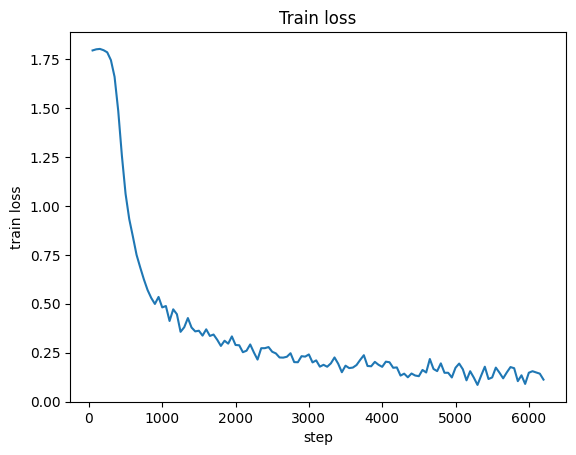

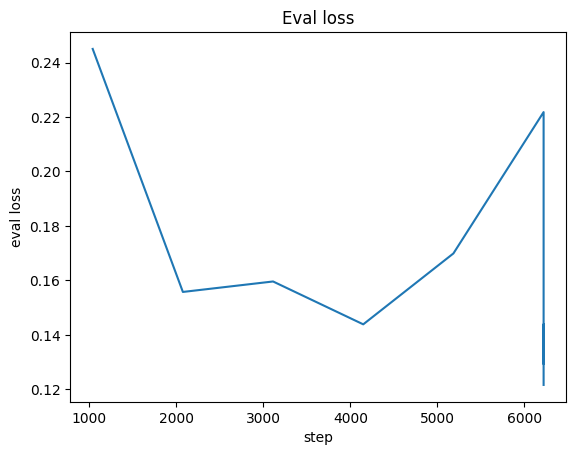

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

    Director       0.94      1.00      0.97       147
      Junior       0.90      1.00      0.95        62
        Lead       1.00      0.98      0.99       532
  Management       0.82      0.91      0.86       113
Professional       0.00      0.00      0.00         0
      Senior       0.99      0.93      0.96       560

    accuracy                           0.96      1414
   macro avg       0.77      0.80      0.79      1414
weighted avg       0.97      0.96      0.97      1414



In [183]:
cls_trainer_syn, (cls_train_pred_syn, cls_val_pred_syn, cls_test_pred_syn), (label2id_syn, id2label_syn) = run_classification(
    train_df_aug,
    val_df_base,
    df_seniority_test,
    out_dir="seniority_ft_cls_syn"
)

## Classification results with synthetic data (in-distribution)

### Loss curves

Training loss decreases smoothly and consistently, which suggests stable optimization even with oversampling and synthetic augmentation. Validation loss drops strongly in the first epochs and then fluctuates slightly, but without a clear upward trend. Overall, the curves look consistent with early stopping around epoch 4 and do not indicate severe overfitting.

### In-distribution metrics (classification)

Accuracy is high and fairly consistent across splits:

- Train: ~0.93  
- Validation: ~0.96  
- Test: ~0.96  

Test accuracy is slightly higher than training accuracy because we oversample only the training split, which makes the training distribution harder (more minority-class cases, less dominated by the easy majority classes). We keep validation and test untouched so they reflect the original data distribution and give a fair, realistic estimate of generalization.

Macro F1 is substantially lower than accuracy:

- Train: ~0.93  
- Validation: ~0.79  
- Test: ~0.79  

This gap indicates uneven performance across classes. Accuracy is dominated by frequent classes (Senior, Lead), which are predicted very well and therefore inflate overall accuracy. Macro F1, in contrast, gives equal weight to each class and is strongly affected by weaker performance on minority and harder classes (Junior, Management, and especially Professional).

On the training split, oversampling forces the model to pay attention to minority classes, which improves macro F1 there. On validation and test, however, these minority classes remain rare and harder to predict, so macro F1 drops while accuracy stays high.


`Professional` shows **0 support** in the validation/test classification report because these splits come from the original fine-tuning dataset (`df_seniority`), and that dataset does not contain the label `Professional` at all. The synthetic data was only added to the **training split**, so the validation and test sets remain “clean” samples from the original distribution and label space.

Compared to the regression without the synthetic data, the classification approach performs worse in-distribution (especially in macro F1). This is expected: classification is a harder objective, oversampling introduces many duplicated examples, and the synthetic labels are noisy (prompt-based accuracy around ~60%), which can reduce clean in-distribution performance. However, classification is still the more relevant setup for the CV setting, because it allows us to include `Professional` and directly model the discrete label space that appears in production data.

The gap between accuracy and macro F1 shows that learning is uneven across classes. However, macro F1 values around 0.79 on validation and test still indicate that the model learns class-specific patterns beyond the majority labels, rather than memorizing only frequent classes. This suggests successful learning under class imbalance, though with remaining weaknesses on minority classes.



In [184]:
# Out-of-distribution eval for classification model
cv_cls = jobs_annotated_df[["text", "label"]].copy()

# map string labels -> class ids of the SYNTHETIC-trained classifier
cv_cls["labels"] = cv_cls["label"].map(label2id_syn)

# drop rows whose labels are not in the classifier label space
cv_cls = cv_cls.dropna(subset=["labels"]).copy()
cv_cls["labels"] = cv_cls["labels"].astype(int)

cv_ds = to_hf_dataset(cv_cls, label_col="labels")

cv_pred = predict_table_cls(
    cls_trainer_syn,
    cv_ds,
    cv_cls[["text", "label"]],
    id2label_syn
)

print("CV accuracy:", cv_pred["correct"].mean())
print("CV F1:", f1_score(cv_pred["label"], cv_pred["pred_label"], average="macro"))


Map:   0%|          | 0/623 [00:00<?, ? examples/s]

CV accuracy: 0.6163723916532905
CV F1: 0.5586130921660488


Without synthetic data, the regression-based model achieves a **CV threshold-accuracy of ~0.51** with an **MAE of ~0.76**, indicating that predictions are often off by nearly one seniority level on average. This reflects the difficulty of generalizing to CV data when certain labels (especially *Professional*) are missing or underrepresented during fine-tuning.

After adding **synthetic data and applying oversampling**, the classification model improves substantially:
- **CV accuracy increases to ~0.62**
- **CV F1-macro reaches ~0.56**

The macro F1 of ~0.56 indicates **moderate and uneven performance across classes**:
- Macro F1 weights all classes equally, so weaker performance on minority or ambiguous classes (especially *Professional*) has a strong negative impact.
- In this context, the score suggests that the model learned meaningful class distinctions, but still struggles to separate closely related seniority levels.

For an out-of-distribution CV setting with noisy, short job titles and limited labeled data, this score is acceptable as a baseline, but it also highlights clear room for improvement.

This shows that synthetic augmentation helps the model better capture underrepresented classes and improves overall robustness under distribution shift.

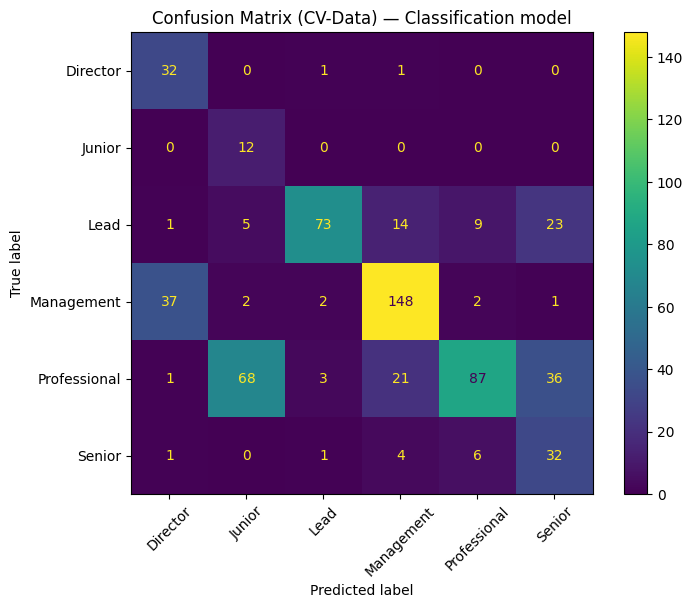

In [187]:
# consistent label order (important!)
labels_order = list(label2id_syn.keys())  # or: [id2label_syn[i] for i in range(len(id2label_syn))]

y_true = cv_pred["label"].astype(str)
y_pred = cv_pred["pred_label"].astype(str)

cm = confusion_matrix(y_true, y_pred, labels=labels_order)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_order)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45, values_format="d")  # counts, not %
plt.title("Confusion Matrix (CV-Data) — Classification model")
plt.show()


The confusion matrix reveals the following about classifying the cv data:
- **Management** is classified very reliably (strong diagonal, 148 correct predictions), suggesting that managerial job titles are linguistically distinctive.
- **Director** also shows strong performance with few confusions, likely due to clear lexical markers (e.g., *Director*, *Head of*).
- **Junior** is mostly predicted correctly when present, indicating that explicit junior-level cues are learned effectively.

The largest errors occur between **adjacent or semantically overlapping classes**:
- **Professional** is frequently confused with *Junior*, *Senior*, and *Management*.  
  This is expected because “Professional” is a broad category without strong lexical signals and is often implicit rather than explicit in job titles.
- **Lead** is often misclassified as *Management* or *Senior*, reflecting ambiguity between technical leadership and people management roles.
- **Senior ↔ Professional** confusions remain common, indicating that the boundary between these classes is still not well defined by the model.

Why do these errors persist?
- **Insufficient high-quality Professional examples**:  
  Even with synthetic data, the *Professional* class remains relatively small and heterogeneous.
- **Label ambiguity in CV data**:  
  Many job titles do not explicitly encode seniority and require contextual information not available to the model.
- **Domain shift**:  
  The synthetic and curated training data differs in style and noise level from real CV titles, limiting generalization.


## 3. Regression with augumented data

For better comparison between the first modell we also run a regression with synthetic data

In [ ]:
reg_trainer_syn, (reg_train_pred_syn, reg_val_pred_syn, reg_test_pred_syn) = run_regression(
    train_df_aug,
    val_df_base,
    df_seniority_test,
    out_dir="seniority_ft_reg_syn"
)

Map:   0%|          | 0/8485 [00:00<?, ? examples/s]

Map:   0%|          | 0/1414 [00:00<?, ? examples/s]

Map:   0%|          | 0/1415 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-3324470351.py:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Mae,Acc Thresh,F1 Macro
1,1.281300,0.708618,0.726421,0.283593,0.159929
2,0.375000,0.329954,0.489905,0.618105,0.509973
3,0.333200,0.180491,0.322348,0.920792,0.730562


In [188]:
# Out-of-distribution eval for REGRESSION model (synthetic run)
cv_reg = jobs_annotated_df[["text", "label"]].copy()

# map string labels -> ordinal float targets (1..6)
cv_reg["labels"] = cv_reg["label"].map(ORD_MAP).astype(float)

cv_ds = to_hf_dataset(cv_reg, label_col="labels")

cv_pred = predict_table_reg(
    reg_trainer_syn,
    cv_ds,
    cv_reg[["text", "label"]]
)

print("CV threshold-accuracy:", (cv_pred["pred_label"] == cv_pred["label"]).mean())
print("CV MAE:", mean_absolute_error(cv_reg["labels"].values, cv_pred["pred_score"].values))
print("CV F1:", f1_score(cv_pred["label"], cv_pred["pred_label"], average="macro"))


Map:   0%|          | 0/623 [00:00<?, ? examples/s]

NameError: name 'reg_trainer_syn' is not defined

## Fine Tuning Conclusion

Synthetic data and oversampling clearly **improve out-of-production performance** compared to the regression baseline, but they do not fully solve class ambiguity.  
Most remaining errors occur between neighboring seniority levels, which suggests that further gains would require:
- more diverse and realistic *Professional* examples,
- richer input context (e.g., job descriptions),

In summary, the model demonstrates meaningful learning under distribution shift, but the macro F1-score shows that class imbalance and semantic overlap—especially for *Professional*—remain the dominant challenges.